### Setup

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Nov  7 14:25:20 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip "/content/drive/MyDrive/Final_Project/data/frames.zip" -d "/content/data" >/dev/null

In [ ]:
import os
# os.chdir("/content/drive/MyDrive/Final_Project")
os.chdir("/content")

In [ ]:
os.listdir()

['.config', 'data', 'drive', 'sample_data']

In [ ]:
import cv2
import glob
from PIL import Image


from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import pickle

from google.colab.patches import cv2_imshow

import torch
import torch.nn as nn
import torch.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from notebooks.face_models import MobileFaceNet

### Dataset

In [ ]:
train_frames_dir = "data/frames/train/"
val_frames_dir = "data/frames/validation/"

print(len(os.listdir(train_frames_dir)))
print(len(os.listdir(val_frames_dir)))

84
21


In [ ]:
path_to_csv = "data/engagement_labels.csv"

In [ ]:
def read_bbox_file(path):
    with open(path, "r") as f:
        bbox = f.read()
  
    return [int(b) for b in bbox.split()]

class EngagementDataset(Dataset):

    def __init__(self, csv_file, root_dir, transform, bb_path):
        self.video_labels = dict(pd.read_csv(csv_file).values)
        self.root_dir = root_dir
        self.transform = transform

        self.frame_paths, self.labels = self.get_data()
        # self.bboxes = [read_bbox_file(self.frame_paths[0].replace('.jpg', '.txt'))]
        if bb_path is not None:
            self.bboxes = pickle.load(open(bb_path, 'rb'))

    def __len__(self):
        return len(self.frame_paths)

    def __getitem__(self, idx):
        try:
            frame_path = self.frame_paths[idx]
            label = float(self.labels[idx])

            frame_image = Image.open(frame_path)
            
            if self.bboxes is not None:
                x1, y1, x2, y2 = self.bboxes[idx]
            else:
                bbox_path = frame_path.replace(".jpg", ".txt")
                x1, y1, x2, y2 = read_bbox_file(bbox_path) #self.bboxes[idx]

            extra_margin = 10
            face = frame_image.crop((max(0, x1 - extra_margin), max(0, y1 - extra_margin),  min(frame_image.size[0], x2 + extra_margin), min(frame_image.size[1], y2 + extra_margin)))
            # face = frame_image[max(0, y1 - extra_margin):y2 + extra_margin, max(0, x1 - extra_margin):x2 + extra_margin]  # using this because original crops seem to be small
            
            sample = {'face': face, 'label': label}
            if self.transform:
                sample = self.transform(sample)

            return sample
        except:
            return(self.__getitem__(0))

    def get_data(self):
        frame_paths, labels, bboxes = [], [], []

        for video_folder in tqdm(sorted(os.listdir(self.root_dir)), desc="Collecting paths"):
            label = self.video_labels.get(video_folder, None)
            if not label:
                continue
            float_label = float(label.replace(",", "."))

            bbox_paths = glob.glob(os.path.join(self.root_dir, video_folder, "*.txt"))
            f_paths = [p.replace(".txt", ".jpg") for p in bbox_paths]  # there are some missing bboxes, so we pick those with bboxes

            frame_paths += f_paths
            labels += [float_label] * len(f_paths)
            # bboxes += [read_bbox_file(bbox_path) for bbox_path in bbox_paths]

        assert len(frame_paths) == len(labels)

        return frame_paths, labels #, bboxes

In [ ]:
resize = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.Resize((112,112)),
    transforms.ToTensor()
])

def preprocess(sample, transform=resize):
    
    sample['face'] = transform(sample['face'])
    return sample

In [ ]:
class EasyDataset(Dataset):
    def __init__(self, data_path):
        self.data = pickle.load(open(data_path, 'rb'))

    def __getitem__(self, idx):
        # self.data[idx][0] contains original index
        sample = self.data[idx][1]
        return sample
    
    def __len__(self):
        return len(self.data)

In [ ]:
train_dataset = EngagementDataset(csv_file=path_to_csv, root_dir=train_frames_dir, transform=preprocess, bb_path='data/train_bb.pkl')
# train_dataset = EasyDataset('data/faces_train.pkl')
# train_fast_dbataset = FastAndBigDataset(train_dataset)

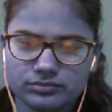

0.66


In [ ]:
sample = train_dataset[0]
cv2_imshow((sample["face"].permute(1, 2, 0).numpy()*255))
print(sample["label"])

In [ ]:
val_dataset = EngagementDataset(csv_file=path_to_csv, root_dir=val_frames_dir, transform=preprocess, bb_path='data/val_bb.pkl')
# val_dataset = EasyDataset('data/faces_val.pkl')

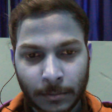

0.66


In [ ]:
i = np.random.randint(0, len(val_dataset))
sample = val_dataset[i]
cv2_imshow((sample["face"].permute(1, 2, 0).numpy()*255))
print(sample["label"])

### Model

In [ ]:
batch_size = 16 
# Исправить!
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
feature_extractor = MobileFaceNet(512)
feature_extractor.load_state_dict(torch.load('/content/drive/MyDrive/Final_Project/models/Pretrained/model_mobilefacenet.pth'))
model = nn.Sequential(
    feature_extractor,
    nn.Linear(512, 1)
)
model.train()
model.cuda()
print('')

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.SmoothL1Loss()
n_epochs = 10

In [ ]:
# error - 1006th batch (batch_size = 16)

In [ ]:
for epoch in range(1, n_epochs):
    model.train()
    for batch in tqdm(train_dataloader):
        
        x = batch['face'].cuda()
        labels = batch['label'].cuda()
        preds = model(x).squeeze(1)
        loss = criterion(labels.float(), preds)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    model.eval()
    with torch.no_grad():
        val_preds = []
        for batch in tqdm(val_dataloader):
            try:
                x = batch['face'].cuda()
                preds = model(x)
                val_preds.append(preds)
            except:
                preds = torch.zeros((batch_size, 1)).float().cuda()
                val_preds.append(preds)
        val_preds_cuda = torch.cat(val_preds, dim=0).squeeze(1)
        val_labels = torch.Tensor(val_dataset.labels).float().cuda()
        val_loss = criterion(val_labels, val_preds_cuda).item()
        print(f'mobilenet_epoch{epoch}_loss_{val_loss:.2f}')
    torch.save(model, f'models/checkpoints/mobilenet_epoch{epoch}_loss_{val_loss:.3f}.pth')

  0%|          | 0/3215 [00:00<?, ?it/s]

  0%|          | 0/1175 [00:00<?, ?it/s]

mobilenet_epoch1_loss_0.04


  0%|          | 0/3215 [00:00<?, ?it/s]

  0%|          | 0/1175 [00:00<?, ?it/s]

mobilenet_epoch2_loss_0.04


  0%|          | 0/3215 [00:00<?, ?it/s]

  0%|          | 0/1175 [00:00<?, ?it/s]

mobilenet_epoch3_loss_0.06


  0%|          | 0/3215 [00:00<?, ?it/s]

  0%|          | 0/1175 [00:00<?, ?it/s]

mobilenet_epoch4_loss_0.06


  0%|          | 0/3215 [00:00<?, ?it/s]

  0%|          | 0/1175 [00:00<?, ?it/s]

mobilenet_epoch5_loss_0.05


  0%|          | 0/3215 [00:00<?, ?it/s]

  0%|          | 0/1175 [00:00<?, ?it/s]

mobilenet_epoch6_loss_0.05


  0%|          | 0/3215 [00:00<?, ?it/s]

  0%|          | 0/1175 [00:00<?, ?it/s]

mobilenet_epoch7_loss_0.06


  0%|          | 0/3215 [00:00<?, ?it/s]

  0%|          | 0/1175 [00:00<?, ?it/s]

mobilenet_epoch8_loss_0.05


  0%|          | 0/3215 [00:00<?, ?it/s]

  0%|          | 0/1175 [00:00<?, ?it/s]

mobilenet_epoch9_loss_0.07


In [ ]:
def getitem(dataset, idx):
    frame_path = dataset.frame_paths[idx]
    label = float(dataset.labels[idx])

    frame_image = Image.open(frame_path)
    
    if dataset.bboxes is not None:
        x1, y1, x2, y2 = dataset.bboxes[idx]
    else:
        bbox_path = frame_path.replace(".jpg", ".txt")
        x1, y1, x2, y2 = read_bbox_file(bbox_path) #self.bboxes[idx]

    extra_margin = 10
    face = frame_image.crop((max(0, x1 - extra_margin), max(0, y1 - extra_margin),  min(frame_image.size[0], x2 + extra_margin), min(frame_image.size[1], y2 + extra_margin)))
    # face = frame_image[max(0, y1 - extra_margin):y2 + extra_margin, max(0, x1 - extra_margin):x2 + extra_margin]  # using this because original crops seem to be small
    
    sample = {'face': face, 'label': label}
    if dataset.transform:
        sample = dataset.transform(sample)

    return sample

In [ ]:
faces_train = []
for i in tqdm(range(len(train_dataset))):
    try:
        sample = getitem(train_dataset, i)
        faces_train.append((i, sample))
    except:
        print(i)
pickle.dump(faces_train, open('data/faces_train.pkl', 'wb'))

  0%|          | 0/51436 [00:00<?, ?it/s]

16107
16108
16109
16110
16111


In [ ]:
faces_val = []
for i in tqdm(range(len(val_dataset))):
    try:
        sample = getitem(val_dataset, i)
        faces_val.append((i, sample))
    except:
        print(i)
pickle.dump(faces_val, open('data/faces_val.pkl', 'wb'))

  0%|          | 0/18791 [00:00<?, ?it/s]

In [ ]:
criterion_val = nn.MSELoss()

In [ ]:
model=torch.load('/content/drive/MyDrive/Final_Project/models/checkpoints/mobilenet_epoch1_loss_0.04.pth')

NameError: ignored

In [ ]:
model.eval()
model.cuda()
with torch.no_grad():
    val_preds = []
    for batch in tqdm(val_dataloader):
        try:
            x = batch['face'].cuda()
            preds = model(x)
            val_preds.append(preds)
        except:
            preds = torch.zeros((batch_size, 1)).float().cuda()
            val_preds.append(preds)
    val_preds_cuda = torch.cat(val_preds, dim=0).squeeze(1)
    val_labels = torch.Tensor(val_dataset.labels).float().cuda()
    val_loss = criterion_val(val_labels, val_preds_cuda).item()

In [ ]:
val_loss

0.0890982449054718